# eQTL Processing

In [1]:
import glob
import os
import subprocess

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

In [2]:
outdir = os.path.join(ciepy.root, 'output',
                      'eqtl_processing')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'eqtl_processing')
cpy.makedir(private_outdir)

In [3]:
exp = pd.read_table(os.path.join(
        ciepy.root, 'output', 'eqtl_input', 
        'tpm_log_filtered_phe_std_norm_peer_resid.tsv'), 
                    index_col=0)

## Results

In [6]:
# This calculates empirical p-values based on the p-values from permutations.
min_fns = glob.glob(os.path.join(ciepy.root, 'output', 'run_eqtl_analysis', 'results', 
                                 '*', 'minimum_pvalues.tsv'))
fn = os.path.join(outdir, 'pvalues.tsv')
if os.path.exists(fn):
    pvals = pd.read_table(fn, index_col=0,
                          header=None, squeeze=True)
else:
    pvals = pd.Series()

In [5]:
# This calculates empirical p-values based on the p-values from permutations.
min_fns = glob.glob(os.path.join(ciepy.root, 'output', 'run_eqtl_analysis', 'results', 
                                 '*', 'minimum_pvalues.tsv'))
fn = os.path.join(outdir, 'pvalues.tsv')
if os.path.exists(fn):
    pvals = pd.read_table(fn, index_col=0,
                          header=None, squeeze=True)
else:
    pvals = pd.Series()
fn = os.path.join(outdir, 'most_sig.tsv')
if os.path.exists(fn):
    ms = pd.read_table(fn, index_col=0)
else:
    ms = pd.DataFrame()
new_pvals = []
new_genes = []
most_sig = []
most_sig_genes = []
# I can speed this up by using some set commands here.
for fn in min_fns:
    if fn.split(os.path.sep)[-2] not in pvals.index:
        g = fn.split(os.path.sep)[-2]
        new_genes.append(g)
        res_fn = os.path.join(os.path.split(fn)[0], '{}.tsv'.format(g))
        res = ciepy.read_emmax_output(res_fn)
        min_pvals = pd.read_table(fn, header=None, squeeze=True)
        p = (1 + sum(min_pvals <= res.PVALUE.min())) / float(min_pvals.shape[0] + 1)
        new_pvals.append(p)
        t = res[res.PVALUE == res.PVALUE.min()]
        most_sig_genes += [g] * t.shape[0]
        most_sig += list(t.values)
new_pvals = pd.Series(new_pvals, index=new_genes)
pvals = pd.concat([pvals, new_pvals])
pvals.to_csv(os.path.join(outdir, 'pvalues.tsv'), sep='\t')
most_sig = pd.DataFrame(most_sig, index=most_sig_genes,
                        columns=res.columns)
most_sig.columns = [x.lower() for x in most_sig.columns]
most_sig['chrom'] = 'chr' + most_sig.chrom.astype(str)
most_sig['coord'] = most_sig.beg
most_sig['loc'] = most_sig.chrom + ':' + most_sig.coord.astype(str)
most_sig['gene'] = most_sig.index
most_sig = most_sig.drop(['beg'], axis=1)
most_sig = most_sig[['chrom', 'coord', 'loc', 'gene', 'marker_id', 'ns', 'ac', 
                     'callrate', 'genocnt', 'maf', 'stat', 'pvalue', 'beta',
                     'sebeta', 'r2']]
ms = pd.concat([ms, most_sig])
ms.to_csv(os.path.join(outdir, 'most_sig.tsv'), sep='\t')

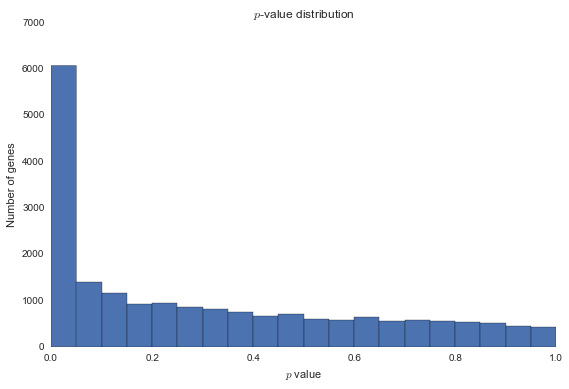

In [28]:
pvals.hist(bins=20)
plt.ylabel('Number of genes')
plt.xlabel('$p$ value')
plt.title('$p$-value distribution')
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'p_value_hist.pdf'))

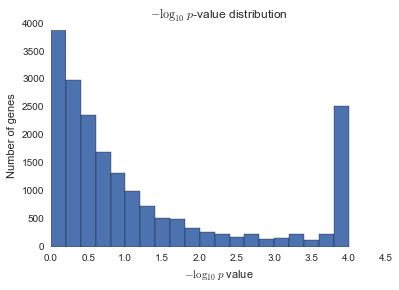

In [8]:
(-np.log10(pvals)).hist(bins=20)
plt.ylabel('Number of genes')
plt.xlabel('$-\log_{10}$ $p$ value')
plt.title('$-\log_{10}$ $p$-value distribution');

## FDR

In [9]:
%%R

library(qvalue)

From the qvalue manual:
    
*The argument stat must be such that the larger the value is the more deviated (i.e., "more extreme")
from the null hypothesis it is. Examples include an F-statistic or the absolute value of a t-statistic.
The argument stat0 should be calculated analogously on data that represents observations from
the null hypothesis distribution. The p-values are calculated as the proportion of values from stat0
that are greater than or equal to that from stat. If pool=TRUE is selected, then all of stat0 is used
in calculating the p-value for a given entry of stat. If pool=FALSE, then it is assumed that stat0
is a matrix, where stat0[i,] is used to calculate the p-value for stat[i]. The function empPvals
calculates "pooled" p-values faster than using a for-loop.*

I think I should be able to use the $-\log_{10}$ $p$-values is a statistic to derive empirical
$p$-values that I can then use with qvalue.

In [10]:
%%R -i pvals -o qvalues,pi0,lfdr,sig

qobj = qvalue(p=pvals, fdr.level=0.05)
#qobj = qvalue(p=pvals)
qvalues <- qobj$qvalues
pi0 <- qobj$pi0
lfdr <- qobj$lfdr
sig <- qobj$significant

summary(qobj)


Call:
qvalue(p = pvals, fdr.level = 0.05)

pi0:	0.4571629	

Cumulative number of significant calls:

        <1e-04 <0.001 <0.01 <0.025 <0.05 <0.1    <1
p-value   2521   3281  4349   5203  6075 7480 19740
q-value      0   2883  3869   4501  5417 6800 19749



`pi0` is the estimated proportion of true null hypotheses.

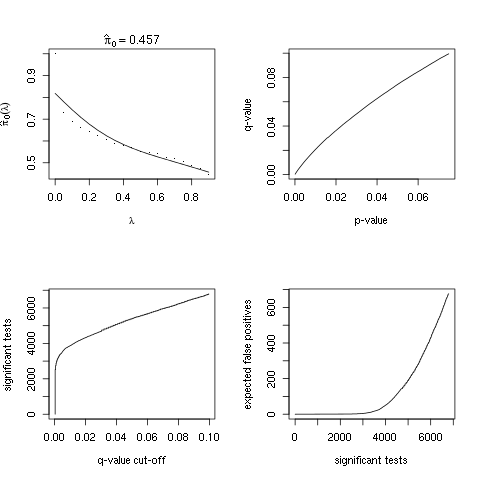

In [11]:
%%R

plot(qobj)

In [ ]:
qvalue_res = pd.DataFrame([list(pvals), list(qvalues), list(sig)], 
                          index=['pvalue', 'qvalue', 'sig'],
                          columns=pvals.index).T
qvalue_res = qvalue_res.sort(['qvalue'])
qvalues = pd.Series(list(qvalues), index=pvals.index)
qvalue_res.index.name = 'gene_id'
qvalue_res.to_csv(os.path.join(outdir, 'qvalues.tsv'), sep='\t')

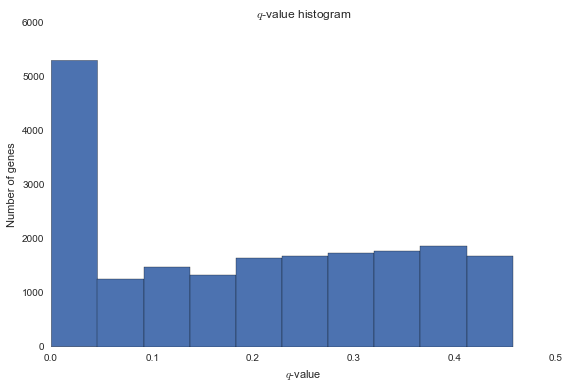

In [29]:
qvalues.hist()
plt.title('$q$-value histogram')
plt.ylabel('Number of genes')
plt.xlabel('$q$-value')
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'q_value_hist.pdf'))

### Significant SNV-Gene Pairs

I'm trying to figure out what the GTEx paper did. My understanding is that they
determined what empirical $p$-value corresponded to a $q$-value of 0.05. They mapped
this empirical $p$-value back to the nominal $p$-values for each gene to produce a 
cutoff for each gene. I guess this mapping would be "what nominal $p$-value yields
the empirical $p$-value that is equivalent to $q=0.05$?"

In [13]:
23 / 1001.

0.022977022977022976

In [14]:
229/ 10001.

0.022897710228977103

## Pseudoheritability

These pseudoheratibility estimates may not be that accurate because I've 
regressed out the PEER factors which could remove broad genetic effects
on expression. I probably want to re-run EMMAX without the PEER factors 
to estimate heritability.

In [ ]:
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing',
                  'pseudoheritability.tsv')
if os.path.exists(fn):
    ph = pd.read_table(fn, index_col=0)
    todo = set(pvals.index) - set(ph.index)
    new_ph = pd.DataFrame(
        -1, index=todo,
        columns=['observed', 'mean_permuted', 'median_permuted'])
else:
    todo = list(ph.index)
    ph = pd.DataFrame(columns=['observed', 'mean_permuted', 'median_permuted'])
    new_ph = pd.DataFrame(
        -1, index=todo,
        columns=['observed', 'mean_permuted', 'median_permuted'])

for i in new_ph.index:
    new_ph.ix[i, 'observed'] = float(open(os.path.join(
            ciepy.root, 'output', 'run_eqtl_analysis', 'results', i, 
            '{}.reml'.format(i))).read().split('\n')[5].split()[1])
    fn = os.path.join(ciepy.root, 'output', 'run_eqtl_analysis', 
                      'results', i, 'permuted_reml.tsv')
    df = pd.read_table(fn, low_memory=False)
    new_ph.ix[i, 'mean_permuted'] = df.h2.mean()
    new_ph.ix[i, 'median_permuted'] = df.h2.median()
ph = pd.concat([ph, new_ph])
ph.to_csv(fn, sep='\t')

## Combined Results

I want to make a file with all EMMAX results combined. I am going to 
sort this file by position and $p$-value. This will allow me to 
collect some stats like the smallest $p$-value observed for each SNV,
how many times a SNV was tested, etc.

Note that the sorting command below takes some time to run.

In [ ]:
out = os.path.join(outdir, 'all_snv_results_sorted.tsv.gz')
if not os.path.exists(out):
    fns = glob.glob(os.path.join(ciepy.root, 'output', 'run_eqtl_analysis', 
                                 'results', 'ENS*', 'ENS*.tsv'))
    import tempfile
    f = tempfile.NamedTemporaryFile()
    f.write('\n'.join(fns) + '\n')
    c = (r"cat {} | xargs -n 32 cat | grep -v '^#' | "
         "sort -T /projects/cdeboever --parallel 16 -k1,1 -k2,2n -k 11 > {}".format(
            f.name, os.path.splitext(out)[0]))
    subprocess.check_call(c, shell=True)
    f.close()
    c = '{}/bgzip {}'.format(cpy.htslib, os.path.splitext(out)[0])
    subprocess.check_call(c, shell=True)
    c = '{}/tabix -p bed {}'.format(cpy.htslib, out)
    subprocess.check_call(c, shell=True)

In [67]:
out = os.path.join(outdir, 'top_snv_results_sorted.tsv.gz')
if not os.path.exists(out):
    i = os.path.join(outdir, 'all_snv_results_sorted.tsv.gz')
    c = ("zcat {} | awk 'a!~$1 || b!~$2 || c!~$3 ; {{a=$1}} {{b=$2}} {{c=$3}}' | "
         "{}/bgzip -c > {}".format(i, cpy.htslib, out))
    subprocess.check_call(c, shell=True)
    c = '{}/tabix -p bed {}'.format(cpy.htslib, out)
    subprocess.check_call(c, shell=True)